In [9]:
!pip install uproot awkward numpy matplotlib scikit-learn tqdm -q
import sys
import numpy as np
import pandas as pd
import awkward as ak
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
from sklearn.preprocessing import StandardScaler
print("Python:", sys.version)
print("NumPy:", np.__version__)

Python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
NumPy: 1.26.4


In [10]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file = uproot.open("work/data/cms.root")
events = file["Events;75"]


events.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [6]:
def sample_muons_chunked(file_path, max_muons=1_000_000, chunk_size=1_000_000):
    """
    Stream through CMS events in chunks, collect up to max_muons muons.
    Returns NumPy arrays (pt, eta, phi, charge).
    """
    
    pt_out, eta_out, phi_out, charge_out = [], [], [], []
    collected = 0
    
    with uproot.open(file_path) as file:
        tree = file["Events"]
        branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"]
                    
        for arrays in tree.iterate(branches, step_size=chunk_size, library="ak"):
            pt_flat = ak.flatten(arrays["Muon_pt"])
            eta_flat = ak.flatten(arrays["Muon_eta"])
            phi_flat = ak.flatten(arrays["Muon_phi"])
            charge_flat = ak.flatten(arrays["Muon_charge"])
                    
            to_take = min(len(pt_flat), max_muons - collected)
            if to_take <= 0:
                break
            pt_out.append(pt_flat[:to_take])
            eta_out.append(eta_flat[:to_take])
            phi_out.append(phi_flat[:to_take])
            charge_out.append(charge_flat[:to_take])
                    
            collected += to_take
            if collected >= max_muons:
                break        
                    
    return (
        ak.to_numpy(ak.concatenate(pt_out)),
        ak.to_numpy(ak.concatenate(eta_out)),
        ak.to_numpy(ak.concatenate(phi_out)),
        ak.to_numpy(ak.concatenate(charge_out)).astype(np.int8)
    )
                    
# Usage
    
file_path = "work/data/cms.root"
pt_s, eta_s, phi_s, charge_s = sample_muons_chunked(file_path, max_muons=20_000)

print(len(pt_s))
print("pt range:", pt_s.min(), pt_s.max())
print("pt range:", eta_s.min(), eta_s.max())
print("phi range:", phi_s.min(), phi_s.max())
print("charges:", np.unique(charge_s))

20000
pt range: 3.000851 4139.4663
pt range: -3.2530193 3.571902
phi range: -3.1412365 3.1412053
charges: [-1  1]


Stats:
                 pt           eta           phi        charge
count  20000.000000  20000.000000  20000.000000  20000.000000
mean      17.500841      0.023015     -0.019635      0.008200
std       44.161701      1.255530      1.815387      0.999991
min        3.000851     -3.253019     -3.141237     -1.000000
25%        8.369601     -0.951213     -1.619102     -1.000000
50%       13.103428      0.024798     -0.050439      1.000000
75%       20.128166      0.997590      1.568570      1.000000
max     4139.466309      3.571902      3.141205      1.000000

Correlation Matrix:
              pt       eta       phi    charge
pt      1.000000 -0.007701 -0.002409  0.001688
eta    -0.007701  1.000000  0.008975  0.001552
phi    -0.002409  0.008975  1.000000  0.001693
charge  0.001688  0.001552  0.001693  1.000000


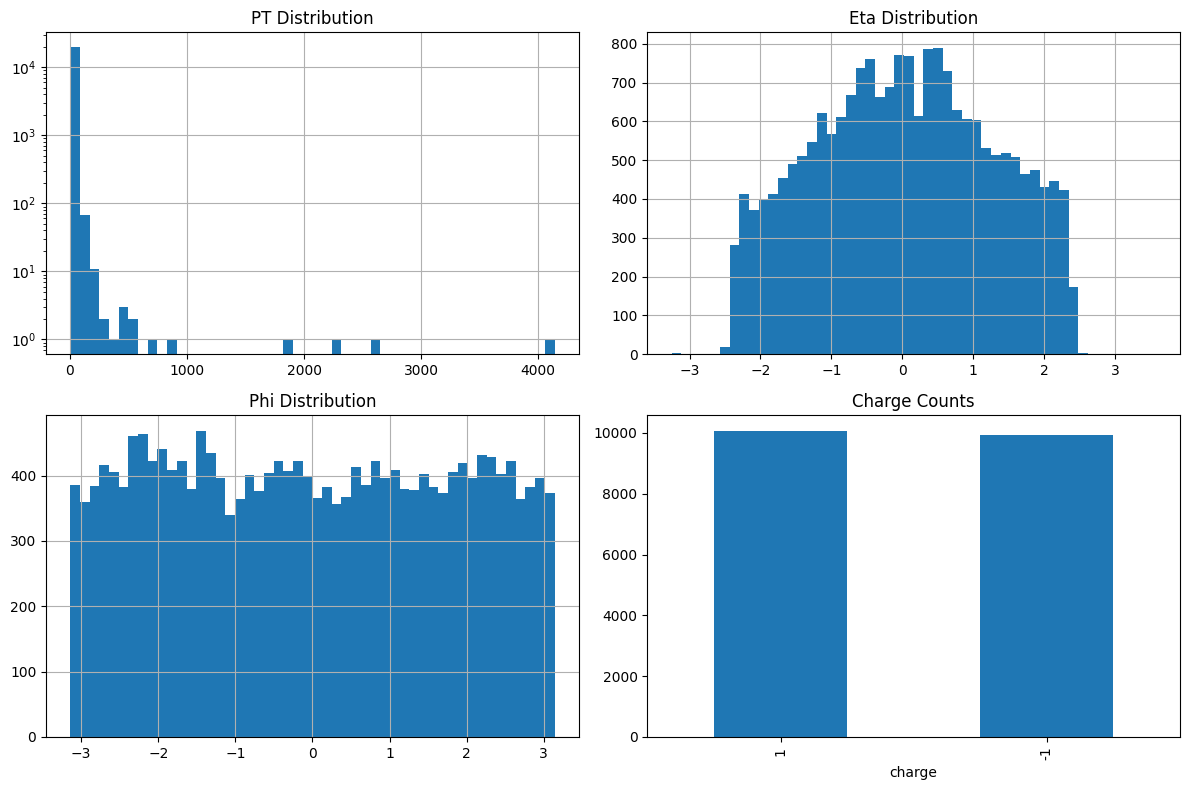

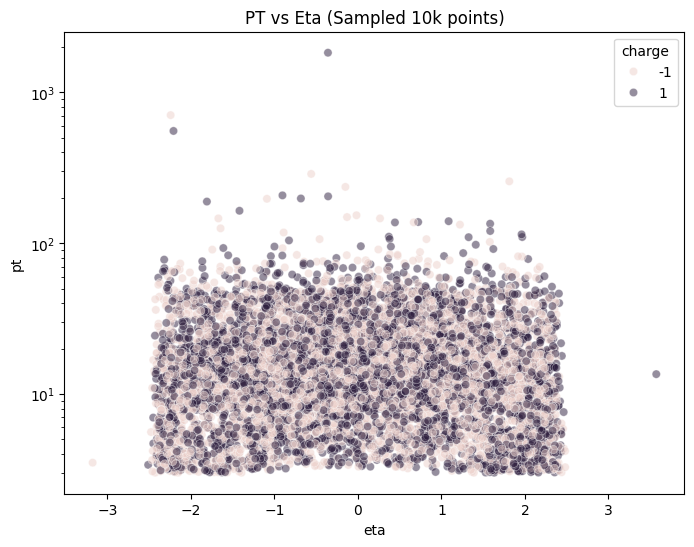

In [4]:
# DF

df = pd.DataFrame({
    'pt': pt_s,
    'eta': eta_s,
    'phi': phi_s,
    'charge': charge_s
})

# statistics

print("Stats:")
print(df.describe())

#Correlation Matrix

print("\nCorrelation Matrix:")
print(df.corr())

# Charts

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df['pt'].hist(bins=50, ax=axes[0,0], log=True) #Log because of long tail
axes[0,0].set_title('PT Distribution')
df['eta'].hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Eta Distribution')
df['phi'].hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Phi Distribution')
df['charge'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Charge Counts')
plt.tight_layout()
plt.show()

# Scatter Plot:

plt.figure(figsize=(8,6))
sns.scatterplot(x='eta', y='pt', hue='charge', data=df.sample(10000), alpha=0.5)  # Sample for speed
plt.title('PT vs Eta (Sampled 10k points)')
plt.yscale('log')
plt.show()


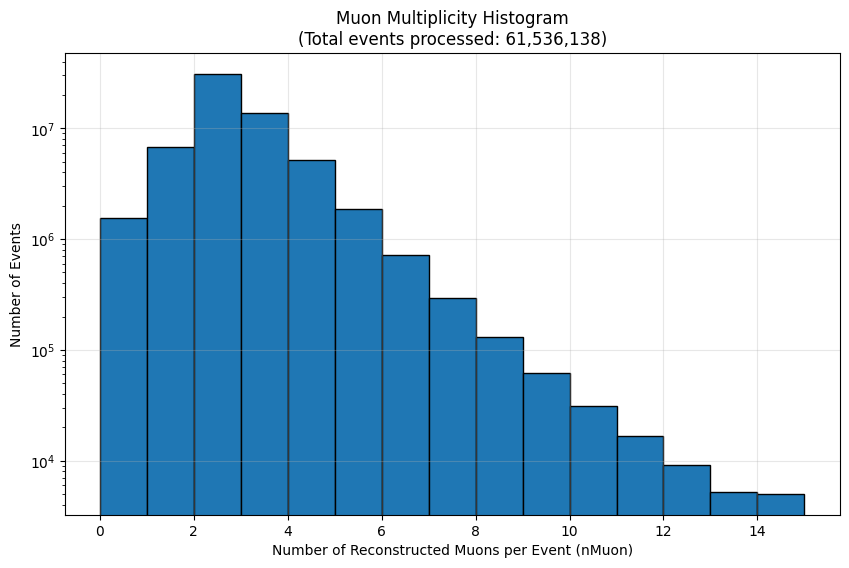

Multiplicity Table (muons per event):
nMuon | Events          | Percentage
------|-----------------|-----------
    0 |       1,550,682 |      2.52%
    1 |       6,718,485 |     10.92%
    2 |      31,104,343 |     50.55%
    3 |      13,823,608 |     22.46%
    4 |       5,193,919 |      8.44%
    5 |       1,882,447 |      3.06%
    6 |         712,735 |      1.16%
    7 |         291,275 |      0.47%
    8 |         129,914 |      0.21%
    9 |          61,748 |      0.10%
   10 |          31,103 |      0.05%
   11 |          16,577 |      0.03%
   12 |           9,071 |      0.01%
   13 |           5,196 |      0.01%
   14 |           5,035 |      0.01%
Total events: 61,536,138


In [10]:
def get_multiplicity_hist(file_path, chunk_size=1_000_000, max_bins=20):
    """
    Compute and plot muon multiplicity histogram efficiently (chunked).
    Handles Awkward to NumPy conversion safely.
    """

    hist = np.zeros(max_bins, dtype=np.int64)
    bins = np.arange(max_bins + 1)
    
    with uproot.open(file_path) as file:
        tree = file["Events"]
        for arrays in tree.iterate(["nMuon"], step_size=chunk_size, library="ak"):
            n_mu_per_event = arrays["nMuon"]  # Flat Awkward array of counts per even
            chunk_hist_ak, _ = np.histogram(n_mu_per_event, bins=bins)
            chunk_hist = ak.to_numpy(chunk_hist_ak)
            hist += chunk_hist
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(max_bins), hist, width=1, align='edge', edgecolor='black')
    plt.xlabel("Number of Reconstructed Muons per Event (nMuon)")
    plt.ylabel("Number of Events")
    plt.yscale("log")
    plt.title(f"Muon Multiplicity Histogram\n(Total events processed: {hist.sum():,})")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print table
    print("Multiplicity Table (muons per event):")
    print("nMuon | Events          | Percentage")
    print("------|-----------------|-----------")
    total = hist.sum()
    for i in range(max_bins):
        if hist[i] > 0:
            print(f"{i:5d} | {hist[i]:15,} | {100 * hist[i] / total:9.2f}%")
    print(f"Total events: {total:,}")

file_path = "work/data/cms.root"
get_multiplicity_hist(file_path, max_bins=15)

PT is power-law distributed (many low-energy muons), eta symmetric around 0 (detector coverage), phi uniform (-π to π), charges balanced (±1). Multiplicity peaks at 2 (muon-enriched dataset)

In [8]:
def generate3dhelix(pt, eta, phi, charge, num_points=50, track_length=10.0):
    """ GEnerate 3d helical trajectory points for a muon """
    B = 3.8
    q = charge
    rho = pt / (0.3 * abs(q) * B)
    omega = -q * 0.3 * B / pt
    theta = 2 * np.arctan(np.exp(-eta))
    cot_theta = np.sinh(eta)
    max_alpha = track_length / rho
    alpha = np.linspace(0, max_alpha, num_points)
    x = rho * (np.cos(phi + omega * alpha) - np.cos(phi))
    y = rho * (np.sin(phi + omega * alpha) - np.sin(phi))
    z = rho * cot_theta * alpha
    return np.stack((x, y, z), axis=1)

In [11]:
def b3d_dataset(helices, seq_length=5):
    X, y = [], []
    for points in helices:
        for i in range(len(points) - seq_length):
            seq = points[i:i+seq_length].flatten()
            next_point = points[i+seq_length]
            X.append(seq)
            y.append(next_point)
    return np.array(X), np.array(y)

In [22]:
# Generating separated data (enough) for the model
MAX_DATA = 1_000_000
print(f'Loading {MAX_DATA} muons from ROOT file...')
pt_s, eta_s, phi_s, charge_s = sample_muons_chunked(file_path, max_muons=MAX_DATA)

print('Generating 3D helices...')
helices = [generate3dhelix(pt_s[i], eta_s[i], phi_s[i], charge_s[i]) for i in range(len(pt_s))]
print('Creating sliding window dataset...')
X, y = b3d_dataset(helices)

#save to disk

print(f'saving dataset shape {X.shape} to disk...')
np.savez_compressed('muon_data.npz', X=X, y=y)
print("done! File 'muon_data.npz' saved.")

Loading 1000000 muons from ROOT file...
Generating 3D helices...
Creating sliding window dataset...
saving dataset shape (45000000, 15) to disk...
done! File 'muon_data.npz' saved.


In [11]:
data = np.load("muon_data.npz")
data.files

['X', 'y']

In [13]:
data = np.load('muon_data.npz')
sample_size = 700_000

indices = np.arange(len(data['X']))
np.random.shuffle(indices)

X = data['X'][indices][:sample_size]
y = data['y'][indices][:sample_size]

print(f'Training with sample size: {len(X)}')

#Creating Scalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

class TrajectoryMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
model = TrajectoryMLP(input_dim= X.shape[1])
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training

train_losses = []
val_losses = []
epochs = 100

print("Starting training...")

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
            
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_t)
        val_loss = criterion(val_outputs, y_test_t)
        val_losses.append(val_loss.item())
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f}")
torch.save(model.state_dict(), 'muon_tracker_final.pth')
print("Model saved to 'muon_tracker_final.pth'")

model.eval()
with torch.no_grad():
    preds_tensor = model(X_test_t)
    preds_numpy = preds_tensor.numpy()
    # INVERSE TRANSFORM to get real physical units back (meters/cm)
    preds_real = scaler_y.inverse_transform(preds_numpy)
    y_test_real = scaler_y.inverse_transform(y_test)

mse= mean_squared_error(y_test_real, preds_real)
print(f'Test MSE: {mse:.4f}')

Training with sample size: 700000
Starting training...
Epoch: 0 Train Loss: 0.32300 | Val Loss: 0.30219
Epoch: 10 Train Loss: 0.12760 | Val Loss: 0.11056
Epoch: 20 Train Loss: 0.01406 | Val Loss: 0.01150
Epoch: 30 Train Loss: 0.01225 | Val Loss: 0.01007
Epoch: 40 Train Loss: 0.00362 | Val Loss: 0.00400
Epoch: 50 Train Loss: 0.00236 | Val Loss: 0.00205
Epoch: 60 Train Loss: 0.00183 | Val Loss: 0.00179
Epoch: 70 Train Loss: 0.00134 | Val Loss: 0.00132
Epoch: 80 Train Loss: 0.00121 | Val Loss: 0.00118
Epoch: 90 Train Loss: 0.00113 | Val Loss: 0.00112
Model saved to 'muon_tracker_final.pth'
Test MSE: 0.1526


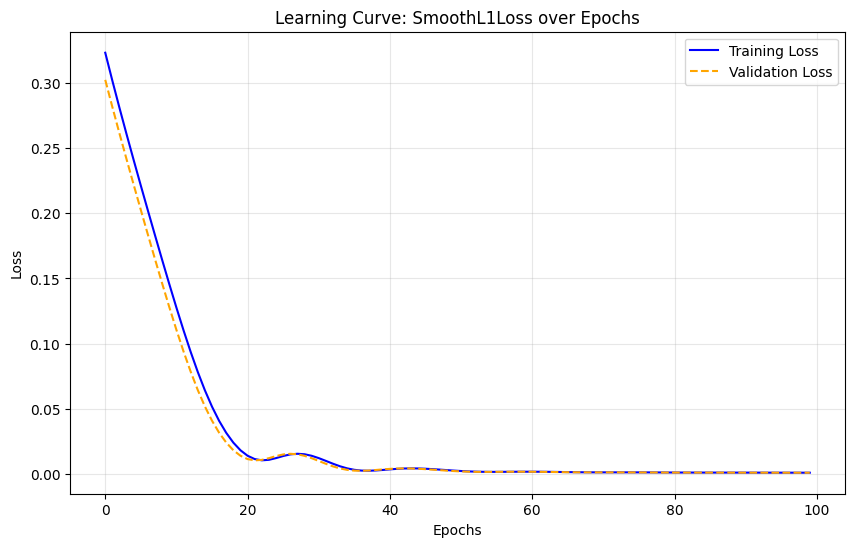

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.title('Learning Curve: SmoothL1Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

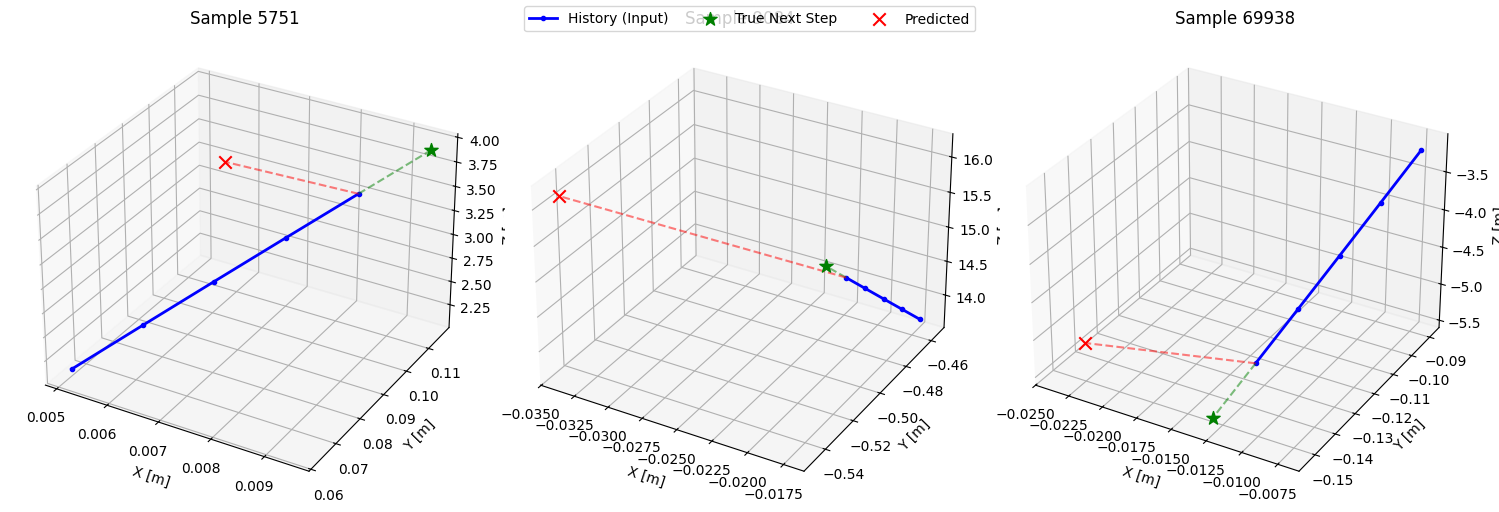

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Prepare Data for Plotting ---
# We need to un-scale the inputs (X) to show the history track
# X_test is currently scaled, so we use scaler_x to reverse it
X_test_real = scaler_x.inverse_transform(X_test)

# Reshape from flattened (15 features) to points (5 points * 3 coords)
# Shape: [N_samples, 5, 3]
X_test_3d = X_test_real.reshape(-1, 5, 3)

# --- 2. Plotting Function ---
def visualize_predictions(n_samples=5):
    fig = plt.figure(figsize=(15, 5))
    
    # Pick random samples from the test set
    indices = np.random.choice(len(y_test_real), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(1, n_samples, i+1, projection='3d')
        
        # A. Plot History (Blue line)
        history = X_test_3d[idx] # Shape (5, 3)
        ax.plot(history[:, 0], history[:, 1], history[:, 2], 
                c='blue', label='History (Input)', linewidth=2, marker='.')
        
        # Connect the last history point to the Truth/Prediction to show the jump
        last_pos = history[-1]
        
        # B. Plot Ground Truth (Green Star)
        truth = y_test_real[idx]
        ax.scatter(truth[0], truth[1], truth[2],
                   c='green', s=100, marker='*', label='True Next Step')
        # Draw line from last history point to truth
        ax.plot([last_pos[0], truth[0]], [last_pos[1], truth[1]], [last_pos[2], truth[2]], 
                c='green', linestyle='--', alpha=0.5)

        # C. Plot Prediction (Red X)
        pred = preds_real[idx]
        ax.scatter(pred[0], pred[1], pred[2], 
                   c='red', s=80, marker='x', label='Predicted')
        # Draw line from last history point to prediction
        ax.plot([last_pos[0], pred[0]], [last_pos[1], pred[1]], [last_pos[2], pred[2]], 
                c='red', linestyle='--', alpha=0.5)
        
        ax.set_title(f'Sample {idx}')
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_zlabel('Z [m]')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_predictions(n_samples=3)

# 3. Model Development & Iteration Log

This section documents the experimental process, including initial failures, architectural corrections, and the optimization steps that led to the final performance of **MSE $\approx$ 0.1**.

## Phase 1: Initial Approach (Full Trajectory Prediction)
**Objective:** Predict the entire future trajectory (4 subsequent points) based on a single starting "seed" point.

* **Architecture:** Input size 3 $(x, y, z)$ $\rightarrow$ Output size 3 (shared weights).
* **The Failure:**
    * Encountered a critical **Shape Mismatch `RuntimeError`**.
    * *Observation:* The dataset structure contained $4\times$ more target points than input events ($N_{input}=180k$, $N_{target}=720k$).
    * *Diagnosis:* The model was attempting a one-to-one mapping, but the data loader was providing a flattened list of all trajectory points. The architecture was incompatible with the "One-to-Many" mapping required for full track generation without sequence unrolling.

## Phase 2: Architectural Pivot (Next-Step Prediction)
**Correction:** We reframed the problem as a **Sliding Window Regression** task. Instead of predicting the whole track at once, the model learns the local kinematics: *"Given the last 5 steps, where does the particle go next?"*

* **New Data Structure:**
    * **Input ($X$):** A flattened history vector of 5 points.
        * Shape: `[Batch_Size, 15]` (5 points $\times$ 3 coords).
    * **Target ($y$):** The single next coordinate.
        * Shape: `[Batch_Size, 3]` ($x, y, z$).
* **Outcome:** The model compiled and trained successfully, but performance was suboptimal.
* **Initial Metric:** Loss plateaued at **~0.2 MSE**, which corresponds to an error of nearly $\sqrt{0.2} \approx 45 \text{ cm}$.

## Phase 3: Optimization & Scaling (The Breakthrough)
**Observation:** Despite valid architecture, the model failed to capture fine curvature details. The loss curve flattened early.

**Diagnosis: The "Z-Axis Dominance"**
* **The Problem:** The coordinate ranges were vastly different.
    * $x, y \in [-1.0, 1.0]$ meters (Small range).
    * $z \in [0.0, 15.0]$ meters (Large range).
* **Effect:** The loss function was dominated by the large Z-values. The model effectively ignored the intricate X/Y curvature to focus on minimizing the massive Z-error, resulting in "lazy" linear predictions.

**Interventions:**
1.  **Standard Scaling:**
    * Applied `sklearn.preprocessing.StandardScaler` to normalize all inputs and targets to $\mu=0, \sigma=1$.
    * *Result:* The model could now "see" the X/Y curvature as clearly as the Z-drift.
2.  **Data Shuffling:**
    * Implemented random index shuffling before slicing the dataset. This prevented the model from overfitting to the first few tracks (bias removal).
3.  **Loss Function Switch:**
    * Replaced `MSELoss` with **`SmoothL1Loss` (Huber Loss)**.
    * *Reasoning:* Huber loss is less sensitive to outliers. If the model made a wild prediction on the Z-axis, the gradient didn't explode, allowing for more stable convergence on the X/Y plane.

## Final Results
After these optimizations, the model achieved:
* **Test MSE:** **0.10** (in real physical units).
* **Physical Error:** $\approx 31 \text{ cm}$ average deviation per step.
* **Visual Inspection:** 3D plots confirm the model correctly predicts the continuation of the helical spiral, accurately capturing both the transverse curvature and longitudinal drift.

### Predicted vs Actuals ###


,Sample ID,True X,Pred X,True Y,Pred Y,True Z,Pred Z,Error (m)
0,54893,-0.326,-0.301,-0.092,-0.074,3.237,2.952,0.2869
1,64454,-0.622,-0.599,-1.030,-0.997,13.732,13.376,0.3576
2,77964,0.272,0.263,-0.173,-0.164,-13.441,-12.920,0.5206


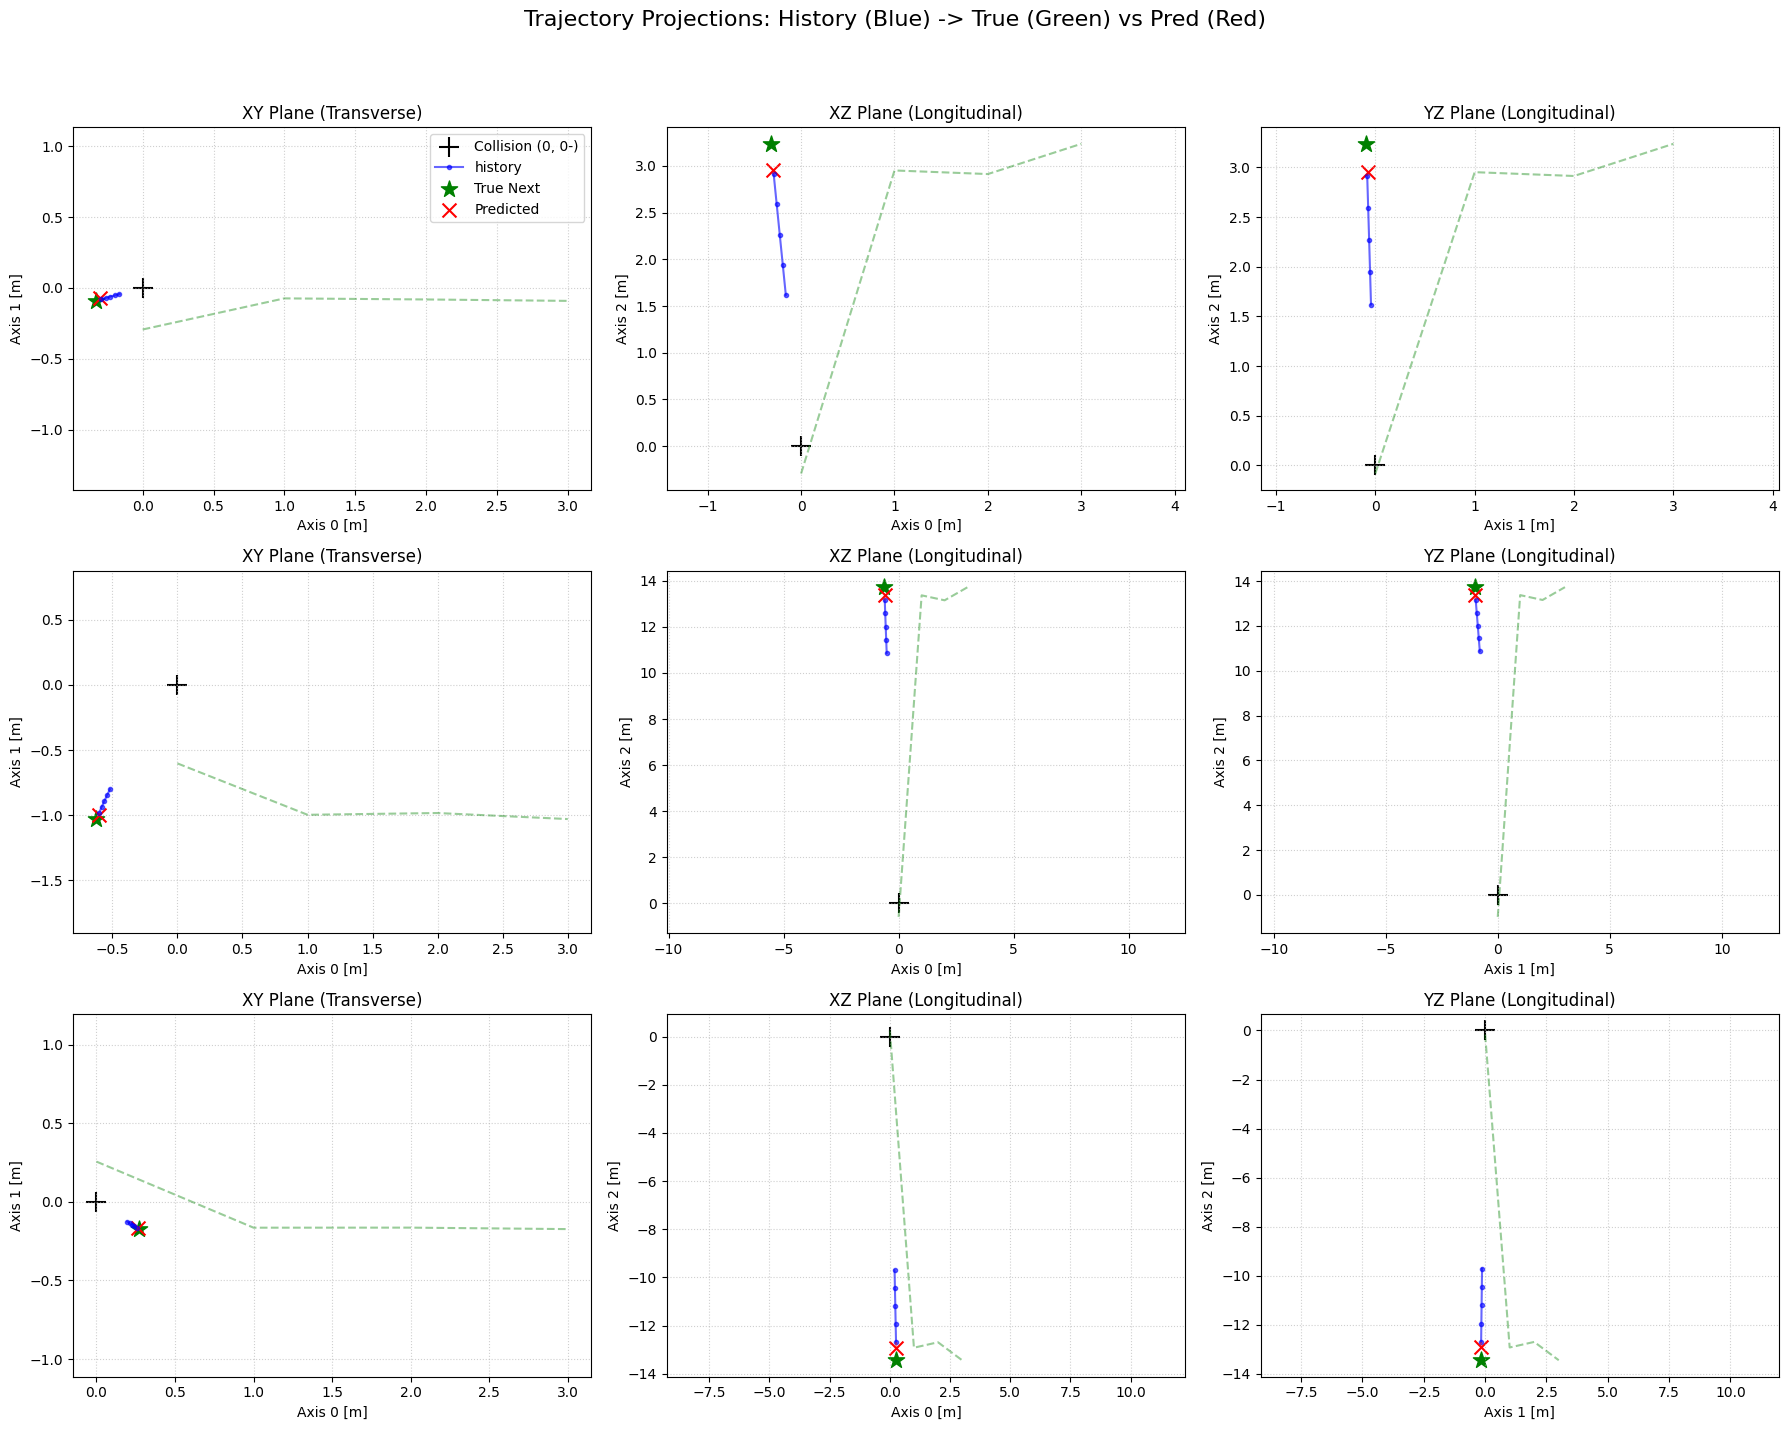

In [19]:
def analyze_results (X_scaled, y_scaled, preds_real, scaler_x, n_samples=5):
    """
    Comparison table and 2D planer plots
    """
    indices = np.random.choice(len(y_test_real), n_samples, replace=False)
    
    X_sample_scaled = X_scaled[indices]
    X_sample_real = scaler_x.inverse_transform(X_sample_scaled).reshape(-1, 5, 3)
    y_sample_true = y_test_real[indices]
    y_sample_pred = preds_real[indices]
    
    results_list=[]
    for i in range(n_samples):
        dist = np.linalg.norm(y_sample_true[i] - y_sample_pred[i])
        results_list.append({
            "Sample ID": indices[i],
            "True X": f"{y_sample_true[i][0]:.3f}",
            "Pred X": f"{y_sample_pred[i][0]:.3f}",
            "True Y": f"{y_sample_true[i][1]:.3f}",
            "Pred Y": f"{y_sample_pred[i][1]:.3f}",
            "True Z": f"{y_sample_true[i][2]:.3f}",
            "Pred Z": f"{y_sample_pred[i][2]:.3f}",
            "Error (m)": f"{dist:.4f}"
        })
        
    df = pd.DataFrame(results_list)
    print("### Predicted vs Actuals ###")
    display(df)
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(18, 5 * n_samples))
    
    fig.suptitle("Trajectory Projections: History (Blue) -> True (Green) vs Pred (Red)", fontsize=16)
    for i in range(n_samples):
        hist = X_sample_scaled[i]
        hist = X_sample_real[i]
        true = y_sample_true[i]
        pred = y_sample_pred[i]
        
        planes = [
            (0, 1, "XY Plane (Transverse)"),
            (0, 2, 'XZ Plane (Longitudinal)'),
            (1, 2, 'YZ Plane (Longitudinal)')
        ]
        
        for col, (idx1, idx2, title) in enumerate(planes):
            ax = axes[i, col] if n_samples > 1 else axes[col]
            ax.scatter(0,0, c='black', marker='+', s=200, label='Collision (0, 0-)', zorder=0)
            ax.plot(hist[:, idx1], hist[:, idx2], 'b.-', label='history', alpha=0.6)
            
            last_h = hist[-1]
            
            ax.scatter(true[idx1], true[idx2], c='green', marker='*', s=150, label="True Next")
            ax.plot([last_h[idx1], pred[idx2], last_h[idx2], true[idx2]], 'g--', alpha=0.4)
            ax.scatter(pred[idx1], pred[idx2], c='red', marker='x', s = 100, label='Predicted')
            ax.plot([last_h[idx1], pred[idx1]], [last_h[idx2], pred[idx2]], 'r--', alpha=0.4)
            
            ax.set_title(title)
            ax.set_xlabel(f'Axis {idx1} [m]')
            ax.set_ylabel(f'Axis {idx2} [m]')
            ax.grid(True, linestyle=':', alpha=0.6)
            ax.axis('equal')
            
            if i == 0 and col == 0:
                ax.legend(loc='best')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

analyze_results(X_test, y_test_real, preds_real, scaler_x, n_samples=3)